This notebook visualizes the trajectory tracking with the trunk system. 

Change model schedules and step sizes and observed tracking performance: \
n: List of used chain models, for instance [16, 8, 'p'] means that we have three phases switching from the 16 link model to the 8 link model and then to the point mass model. \
dt: list of integration step sizes \
N_list: determines the number of shooting intervals in each phase for instance [10,10,10] means that all three models are used for 10 shooting intervals each. \ \

The trajectory considered in the thesis is loaded. A new trajectory_name can be created with Trajectory_finding_script, the user can select points the trajectory is supposed to go trhough, then a spline is fitted through these points to create a reference trajectory to track for the MPC. \ \

Additional settings determine for example if the system is simulated with an acados simulator or in mujoco. 

In [1]:
import mujoco
import numpy as np
import os
from trunk.trunk_mpc_2d_acados import TrunkMPC2DEETracking, TrunkMPC2DOptions
import casadi as ca
import matplotlib.pyplot as plt
from trunk.Trajectory_finding_script import select_periodic_trajectory
from trunk.trajectory_tracking_trunk_closed_loop import closed_loop_ee_tracking_mujoco, closed_loop_ee_tracking_acados
from trunk.trunk_utils import generate_exponential_step_sizes
from trunk.trunk_utils import get_x_and_y_pos
from acados_template import latexify_plot
from utils_shared import get_dir

Settings.

In [ ]:
n = [8, 4, 'p'] # Use 8 link model
N_list = [10, 10, 10]
n_high = 8 # system for simulation, should be set to the initial n value
map_controls = False
nlp_solver_type = 'SQP'

# noise options during closed loop sim, only works with mujoco sim
perturbation_variance = 0.0#1.0
controller_interval = 0.005

ellipse_centers = None #np.array([[0.1, -0.48], [0.0, -0.4]]) 
ellipse_half_axes = None #np.array([[0.03, 0.04], [0.02, 0.02]])
trunk_mpc_2d_options = TrunkMPC2DOptions(n=n, dt=controller_interval, N_list=N_list,n_high=n_high, map_controls=map_controls, nlp_solver_type=nlp_solver_type, ellipse_centers = ellipse_centers, ellipse_half_axes = ellipse_half_axes, ub_x_ee = [0.2, 1e15], lb_x_ee = [-1e15, -1e15]) #0.2 before 

current_dir = get_dir("src/trunk")
xml_path = os.path.join(current_dir, "models", "chain_models", f"chain_{n_high}_links_expanded.xml")
Mjmodel = mujoco.MjModel.from_xml_path(xml_path)
Mjmodel.opt.timestep = 0.001  # Set timestep to 1 ms (500 Hz simulation frequency)
Mjdata = mujoco.MjData(Mjmodel)

# settings regarding reference trajectory
advanced_reference = True # decides between simple circle and an advanced reference trajectory
trajectory_name = "trajectory_oval" # "trajectory_new" if new trajectory is created with the trajectory finding script
frequency = 1.0 # frequency with which the reference trajectory is considered

# Closed-loop sim settings
duration = 10.0  # (seconds)
use_mujoco = False # decides if mujoco odr acados is used for closed loop sim

# Plotting and videos
create_video = False
framerate = 60  # (Hz) Video framerate
plot_open_loop_plan_bool = True # Activate to visualize the open loop plans during simulation
plot_configs = True

# Allows for testing solver switches, for eample a different model schedule when approaching the constraint, not really important here
test_switching = False
if test_switching:
    switching_time = 0.4
    N_list_switch = [15, 15]
    n_switch = [16, 8]
    trunk_mpc_2d_options_switch = TrunkMPC2DOptions(n=n_switch, N_list=N_list_switch,n_high=n_high, map_controls=map_controls, nlp_solver_type=nlp_solver_type)
else:
    switching_time = None

Setup and closed-loop sim.

In [3]:
if not advanced_reference:
    a = 0.05 # Half-length of the ellipsoid along the x-axis (in meters)
    b = 0.05 # Half-length of the ellipsoid along the z-axis (in meters)
    end = -0.5  # End of the trunk in ODE coordinate system
    center_x, center_z = 0, end + b  # Center of the ellipsoid (in meters)
    t = ca.SX.sym('t')
    Phi_x = center_x - a * ca.sin(2 * ca.pi * frequency * t)  # x-coordinate
    Phi_y = center_z - b * ca.cos(2 * ca.pi * frequency * t)  # y-coordinate
    Phi_t = ca.vertcat(Phi_x, Phi_y)
    Phi_t_func = ca.Function('Phi_t', [t], [Phi_t])
    Phi_dot_t = ca.jacobian(Phi_t, t)
    Phi_dot_t_func = ca.Function('Phi_dot_t', [t], [Phi_dot_t])
else:
    Phi_t_func, Phi_dot_t_func = select_periodic_trajectory(n=n[0], frequency=frequency, trajectory_name=trajectory_name, plot=False)

# evaluate one period for plotting
T = 1 / frequency  # Period of the motion
time_steps = np.linspace(0, T, 100)  # 100 time steps within one period

# Evaluate the trajectory using Phi_t_func
trajectory = np.array([Phi_t_func(t_val) for t_val in time_steps])

# Extract x and z coordinates
trajectory_x = trajectory[:, 0]  # x-coordinates
trajectory_z = trajectory[:, 1]  # z-coordinates

# initialize MPC
trunkMPC = TrunkMPC2DEETracking(Phi_t_func, Phi_dot_t_func, trunk_mpc_2d_options)

if test_switching:
    trunkMPC_switching = TrunkMPC2DEETracking(Phi_t_func, Phi_dot_t_func, trunk_mpc_2d_options_switch)
else:
    trunkMPC_switching = None

Loading trajectory from /home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/fading_fidelity_MPC_repo_submission/src/trunk/trajectories_ee_tracking/trajectory_oval.pkl...
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_al

acados_solver_multiphase_ocp_15_1_15_20250605_085253_514242.c: In function ‘multiphase_ocp_15_1_15_20250605_085253_514242_acados_create_with_discretization’:
acados_solver_multiphase_ocp_15_1_15_20250605_085253_514242.c:1450:25: warning: too many arguments for format [-Wformat-extra-args]
 1450 |         fprintf(stderr, "multiphase_ocp_15_1_15_20250605_085253_514242_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o model_16_links_16_8_15_15_015000000000000005_FULL_CONDENSING_HPIPM_model/model_16_links_16_8_15_15_015000000000000005_FULL_CONDENSING_HPIPM_impl_dae_fun_jac_x_xdot_z.o model_16_links_16_8_15_15_015000000000000005_FULL_CONDENSING_HPIPM_model/model_16_links_16_8_15_15_015000000000000005_FULL_CONDENSING_HPIPM_impl_dae_fun_jac_x_xdot_z.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lu

computation time: 0.057279


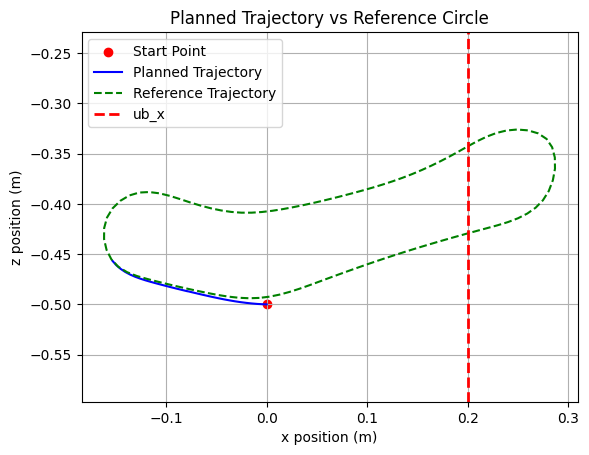

computation time: 0.027883


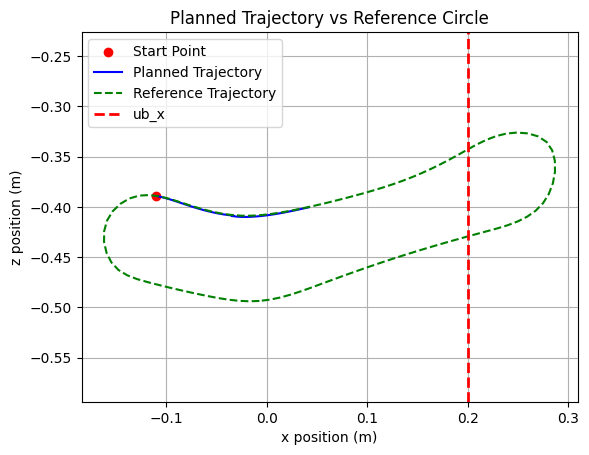

computation time: 0.03698


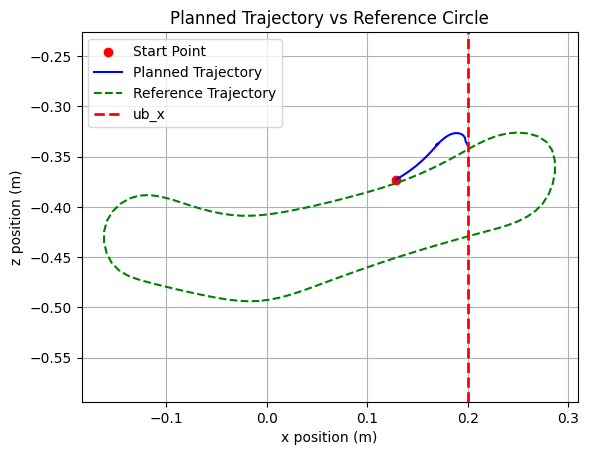

computation time: 0.037


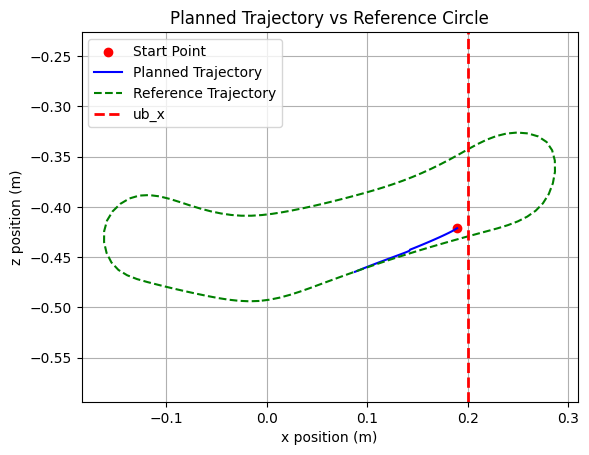

computation time: 0.037891


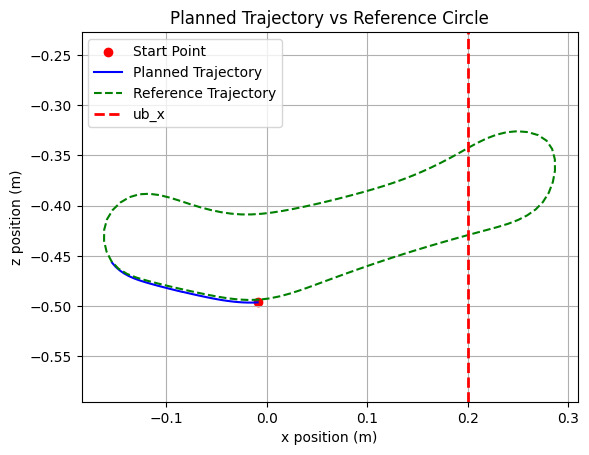

computation time: 0.027885


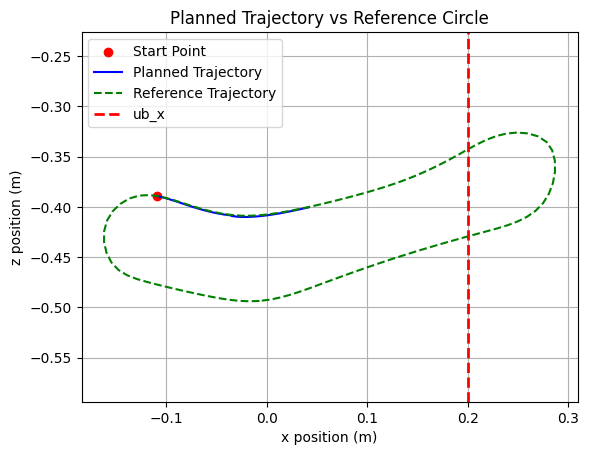

computation time: 0.037305


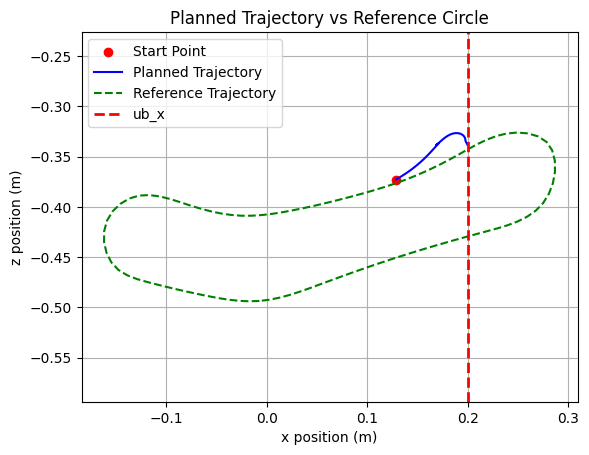

computation time: 0.037542


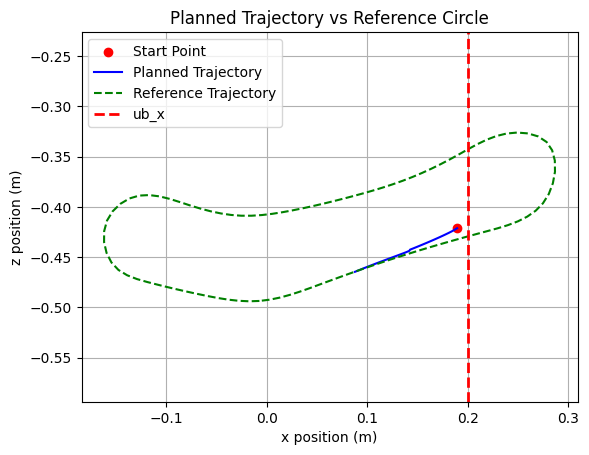

Mean_costs:0.00984054152235432
Simulation done with n: [16, 8]


In [ ]:
# Simulate and display video (if create_video).
ee_site_id = mujoco.mj_name2id(Mjmodel, mujoco.mjtObj.mjOBJ_SITE, "endeffector")

if use_mujoco:
    control_inputs, ee_pos, costs, _, _, _ = closed_loop_ee_tracking_mujoco(n, n_high, Mjmodel, Mjdata, duration, framerate, create_video, plot_open_loop_plan_bool, trajectory_x, trajectory_z, trunkMPC, controller_interval = controller_interval, perturbation_variance=perturbation_variance)
    print(f"Mean_costs:{np.mean(costs)}")
else:
    control_inputs, states, _, ee_pos, costs, _, _, _ = closed_loop_ee_tracking_acados(n, n_high, duration, plot_open_loop_plan_bool, trajectory_x, trajectory_z, trunkMPC, trunkMPC_switching, switching_time)
    print(f"Mean_costs:{np.mean(costs)}")

print('Simulation done with n:', n)

Visualize the results.

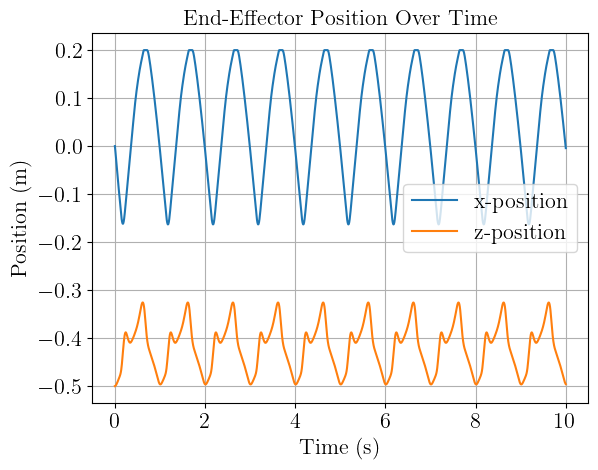

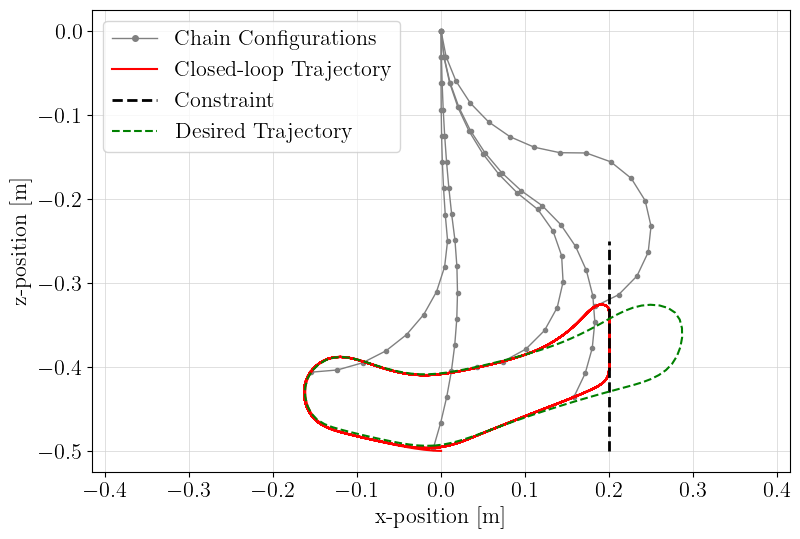

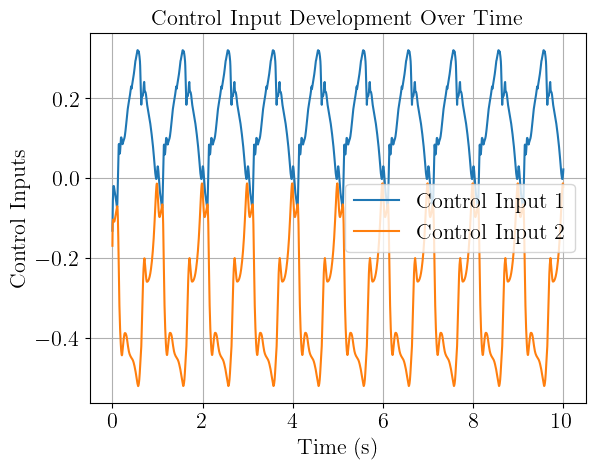

In [ ]:
# Convert endeffector position to numpy array for plotting
ee_pos = np.array(ee_pos)

# Extract time, x, and z positions
time = np.linspace(0, duration, len(ee_pos))
if use_mujoco:
    x_positions = ee_pos[:, 0]
    z_positions = ee_pos[:, 2]
else:
    x_positions = ee_pos[:, 0]
    z_positions = ee_pos[:, 1] 

# Plot x and z end-effector positions over time
plt.figure()
plt.plot(time, x_positions, label='x-position')
plt.plot(time, z_positions, label='z-position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('End-Effector Position Over Time')
plt.legend()
plt.grid()
plt.show()


latexify_plot(fontsize=16)
plt.figure(figsize=(8, 6))

# Plot trunk configurations along trajectory
if not use_mujoco: # states array currently not available with mujoco
    states_array = np.array(states)
    #q_values_first_iteration = states_array[int(1/controller_interval), :n[0]] # q values in first iteration
    link_length = 0.5/n[0]

    # Now plot chain configurations in grey along the trajectory
    if plot_configs:
        num_steps = states_array.shape[0]
        step = 40

        # Plot each chain configuration in grey (no label here)
        for i in range(step, int(1/controller_interval) + step, step):
            angles = states_array[i, :n[0]]
            x_chain, y_chain = get_x_and_y_pos(angles, link_length)
            plt.plot(x_chain, y_chain, color='grey', marker='o', linewidth=1, markersize=3)

        # Add a 'dummy' line for the legend
        plt.plot([], [], color='grey', marker='o', linewidth=1, markersize=4, label='Chain Configurations')


# Plot the development of the end-effector in the x-z plane
plt.plot(x_positions, z_positions , color='red', label='Closed-loop Trajectory')
plt.plot([0.2, 0.2], [-0.5, -0.25], color='black', linestyle='--', linewidth=2.0, label='Constraint')

# Add an ellipsoid with parameters a and b around the origin
plt.plot(trajectory_x, trajectory_z, '--', color='green', label='Desired Trajectory')

plt.xlabel('x-position [m]')
plt.ylabel('z-position [m]')
#plt.title('End-Effector Trajectory in x-z Plane')
plt.axis('equal')  # Make the axes equal
plt.xlim([-0.3, 0.3])  # Set the range from -1.0 to 2.0 on the x-axis
plt.legend(loc="upper left")
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
trunk_plots_dir = get_dir("plots/trunk")
filename_pdf = trunk_plots_dir / "closed_loop_trajectory.pdf"
plt.savefig(filename_pdf, bbox_inches="tight")
filename_pgf = trunk_plots_dir / "closed_loop_trajectory.pgf"
plt.savefig(filename_pgf, bbox_inches="tight")
plt.show()

# Plot control input development
control_inputs = np.array(control_inputs)
time_control = np.linspace(0, duration, len(control_inputs))
plt.figure()
plt.plot(time_control, control_inputs[:, 0], label='Control Input 1')
plt.plot(time_control, control_inputs[:, 1], label='Control Input 2')
plt.xlabel('Time (s)')
plt.ylabel('Control Inputs')
plt.title('Control Input Development Over Time')
plt.legend()
plt.grid()
plt.show()